<a href="https://colab.research.google.com/github/mella30/Deep-Learning-with-Tensorflow-2/blob/main/Course1-Getting_started_with_TensorFlow_2/week3_Validation_Regularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [115]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [116]:
# Save the input and target variables

print(diabetes_dataset.keys())

data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [117]:
# Normalise the target data (this will make clearer training curves)

targets = (targets - targets.mean(axis=0)) / targets.std()

In [118]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [119]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
  model = Sequential([
                      Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(1)
  ])
  return model

model = get_model()

In [120]:
# Print the model summary

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_99 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_100 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_101 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_102 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_103 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_104 (Dense)            (None, 1)               

In [121]:
# Compile the model

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

In [122]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [123]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets)

2/2 [==============================] - 0s 5ms/step - loss: 0.9938 - mae: 0.7509


[0.9938017725944519, 0.7509468793869019]

#### Plot the learning curves

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

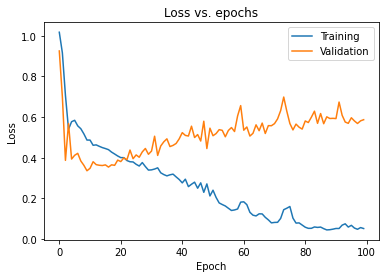

In [124]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [ ]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [ ]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(wd=1e-5, rate=0.3)

In [ ]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [ ]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets)

2/2 [==============================] - 0s 5ms/step - loss: 0.5363 - mae: 0.5745


[0.5363113284111023, 0.5744779706001282]

#### Plot the learning curves

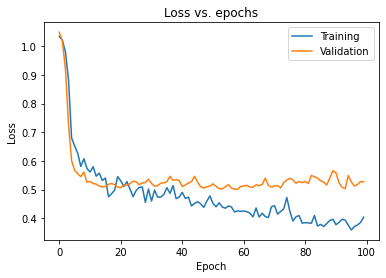

In [ ]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [135]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):

  def on_train_begin(self, logs=None):
    print ("Starting training...")

  def on_epoch_begin(self, epoch, logs=None):
    print(f"Starting epoch {epoch}")

  def on_train_batch_begin(self, batch, logs=None):
    print(f"Training: Starting batch {batch}")

  def on_train_batch_end(self, batch, logs=None):
    print(f"Training: Finished batch {batch}")
  
  def on_epoch_end(self, epoch, logs=None):
    print(f"Finished epoch {epoch}")

  def on_train_end(self, logs=None):
    print("Finished training!")

class TestingCallback(Callback):
  
  def on_test_begin(self, logs=None):
    print ("Starting testing...")

  def on_test_batch_begin(self, batch, logs=None):
    print(f"Testing: Starting batch {batch}")

  def on_test_batch_end(self, batch, logs=None):
    print(f"Testing: Finished batch {batch}")

  def on_test_end(self, logs=None):
    print("Testing training!")

class PredictionCallback(Callback):
  
  def on_predict_begin(self, logs=None):
    print ("Starting prediction...")

  def on_predict_batch_begin(self, batch, logs=None):
    print(f"Prediction: Starting batch {batch}")

  def on_predict_batch_end(self, batch, logs=None):
    print(f"Prediction: Finished batch {batch}")

  def on_predict_end(self, logs=None):
    print("Testing prediction!")

In [128]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

In [129]:
# Compile the model

model.compile(optimizer='adam', loss='mse')

#### Train the model with the callback

In [133]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[TrainingCallback()])

Starting training...
Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 2
Finished training!


In [134]:
# Evaluate the model

model.evaluate(test_data, test_targets, verbose=False, callbacks=[TestingCallback()])

Starting testing...
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Testing training!


0.5385255217552185

In [136]:
# Make predictions with the model

model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])

Starting prediction...
Prediction: Starting batch 0
Prediction: Finished batch 0
Prediction: Starting batch 1
Prediction: Finished batch 1
Testing prediction!


array([[-0.7243193 ],
       [ 0.77043706],
       [-0.5515081 ],
       [ 0.26907623],
       [-0.44181693],
       [ 1.0084205 ],
       [-0.11321896],
       [-0.67986465],
       [-0.61056906],
       [ 0.19714478],
       [-0.7241114 ],
       [-0.9408017 ],
       [ 0.51098055],
       [-0.26864368],
       [ 0.89457643],
       [ 1.2433892 ],
       [ 0.89157504],
       [ 0.28252766],
       [-0.1060192 ],
       [-0.5758515 ],
       [ 0.34279886],
       [-0.72656006],
       [-0.24867167],
       [-0.52860755],
       [-0.8034151 ],
       [-0.9382    ],
       [-0.8156522 ],
       [-0.8607798 ],
       [-0.65740913],
       [ 0.8519082 ],
       [ 0.20383506],
       [ 0.9315334 ],
       [ 0.57739633],
       [ 0.7545868 ],
       [-0.64918554],
       [ 0.5698307 ],
       [-0.705365  ],
       [-0.5720597 ],
       [ 0.9909786 ],
       [ 0.23486455],
       [-0.7752699 ],
       [-0.768039  ],
       [-0.7622524 ],
       [-0.4267943 ],
       [-0.80206233]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [155]:
# Re-train the unregularised model

unregularized_model = get_model()
unregularized_model.compile(optimizer='adam', loss='mse')
unreg_history = unregularized_model.fit(train_data, train_targets, epochs=100,
                                        validation_split=0.15, batch_size=64, verbose=False,
                                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [156]:
# Evaluate the model on the test set

unregularized_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.4952


0.4951954782009125

In [157]:
# Re-train the regularised model

regularized_model = get_regularised_model(1e-5, 0.2)
regularized_model.compile(optimizer='adam', loss='mse')
reg_history = regularized_model.fit(train_data, train_targets, epochs=100,
                                    validation_split=0.15, batch_size=64, verbose=False,
                                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [158]:
# Evaluate the model on the test set

regularized_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.6342


0.6341540813446045

#### Plot the learning curves

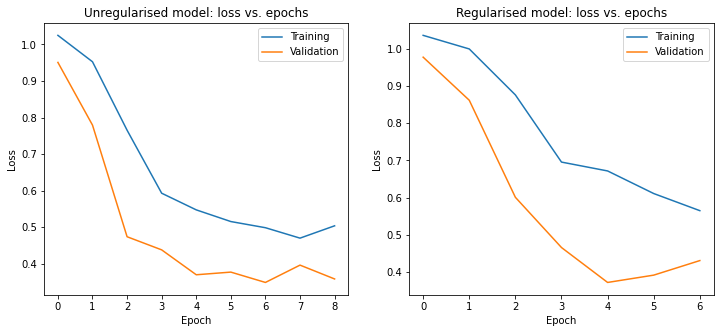

In [159]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()